First, load the data,in this notebook we are using the smokoy mountain data as the example, the input data is already the relative abundance matrix.

In [1]:
import sys
sys.path.append('../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../Data/merge_proportion_asv_smoky_moutain.csv")

In [3]:
data

array([[1.5786533e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.6912335e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.0700000e-05,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        8.2400000e-05, 8.2400000e-05],
       [1.5771320e-03, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
# 1. abundance matrix--> relative abundance matrix
data=FS.relative_abundance(data)
print(np.shape(data))

(59, 1768)


In [6]:
data

array([[1.57865330e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.69123350e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.06999957e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.24000080e-05, 8.24000080e-05],
       [1.57713200e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

Perform multiLabel feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

In [7]:
yList= np.column_stack((burn_label,un_label,duration_label))# y list is a 2D array, each column is a response outcome

In [8]:
yList[:4]

array([['No', 'Natural', 'Annual'],
       ['No', 'Natural', 'Perennial'],
       ['No', 'Urban', 'Perennial'],
       ['No', 'Urban', 'Annual']], dtype=object)

In [9]:
yList.ndim

2

In [10]:
burn_label.ndim

1

In [11]:
yList.shape[1]

3

In [12]:
# 2. calculating H score for each OTU
weights=FS.OTU_H_Score_fun(data,yList)

In [13]:
weights

array([[3.58783345, 4.62436719, 5.89262923, ..., 0.        , 0.        ,
        0.        ],
       [2.4157006 , 1.16409551, 2.79448091, ..., 0.        , 0.        ,
        0.        ],
       [0.1986735 , 0.57734704, 3.25951225, ..., 0.        , 0.        ,
        0.        ]])

In [14]:
weights.shape

(3, 1768)

In [15]:
#check  the H statistics
df1 = pd.DataFrame(weights, index=['burn_label', 'un_label', 'duration_label'])
columns_sig = (df1 > 2.705543454095404).any()
# Count the number of columns where at least one value is larger than 0
count = columns_sig.sum()
print(count)
count_larger= (df1 > 2.705543454095404).sum(axis=1)

# Display the result
print("Number of values larger than significance cutoff in each row:")
print(count_larger)

86
Number of values larger than significance cutoff in each row:
burn_label        56
un_label          29
duration_label    19
dtype: int64


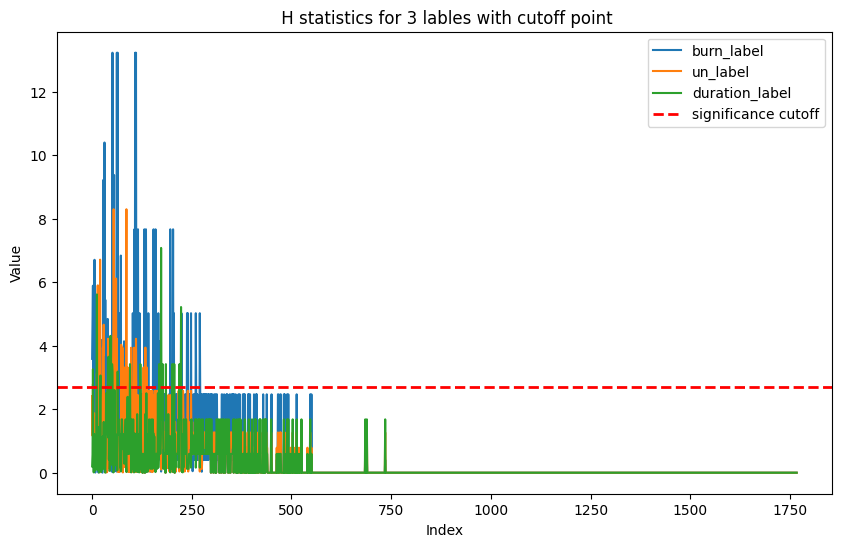

In [16]:
import matplotlib.pyplot as plt
# Plotting each row individually
# Plotting each row individually
plt.figure(figsize=(10, 6))
for row in df1.index:
    plt.plot(df1.columns, df1.loc[row], label=row)

# Add a horizontal line at y=0
plt.axhline(y=2.705543454095404, color='red', linestyle='--', linewidth=2, label='significance cutoff')

# Set plot title and labels
plt.title(' H statistics for 3 lables with cutoff point')
plt.xlabel('Index')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [17]:
# 1 compare burn
burn_label.value_counts()

Burn
Yes    42
No     17
Name: count, dtype: int64

In [18]:
selectedOTU_index, eps=FS.indice_H_sig0(weights[0,:],burn_label)

In [19]:
#subset the relative matrix by the select indices
X_FS = data[:,selectedOTU_index]
np.shape(X_FS)

(59, 56)

In [20]:
iter =30
cls = ["RF","SVM"]

In [21]:
targetLabel=burn_label
X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)


In [22]:
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Random":data
              }
print(np.shape(data))
print(np.shape(X_FS))
print(np.shape(X_lasso))

(59, 1768)
(59, 56)
(59, 16)


This plot shows that the gain in information decreases as we include more OTUs along the ranks. 

In [23]:
# the result of 5-fold cross validation
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures     0.905147  0.972917      0.679412  0.732986
SelectMicro     0.952941  0.988889      0.666912  0.589931
Lasso           0.952206  0.991667      0.501471  0.019444
Random          0.847892  0.914792      0.487892  0.163351


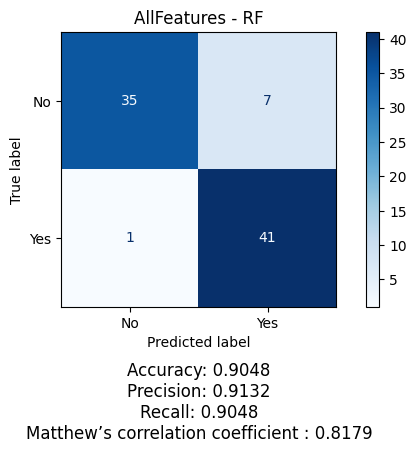

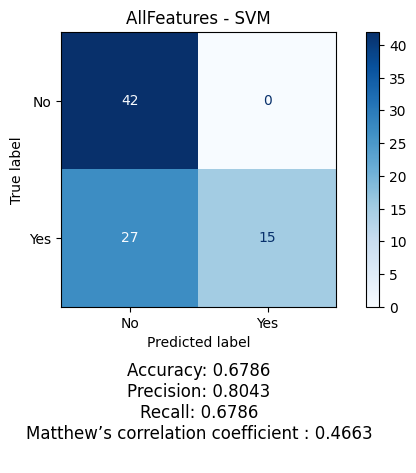

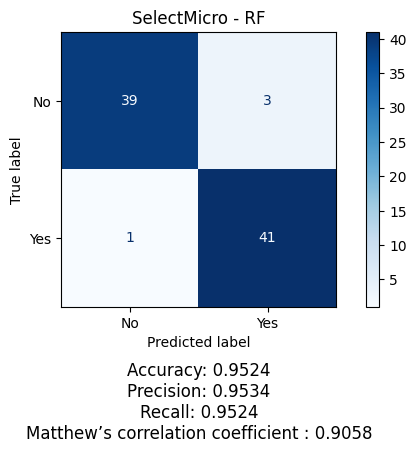

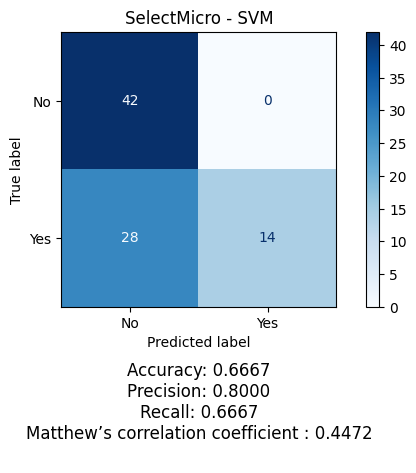

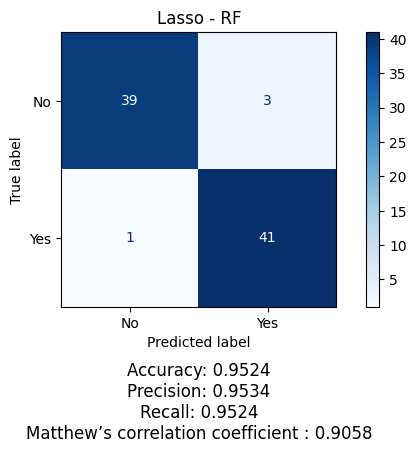

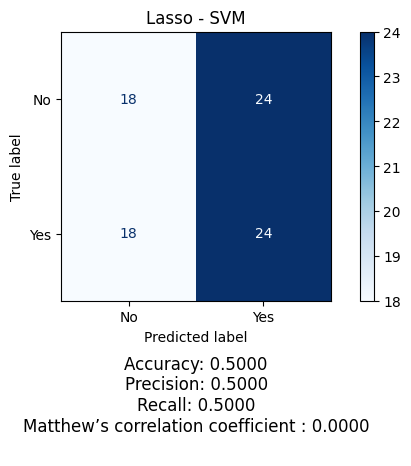

In [24]:
# do not use plotmacro_confusion_matrices (not for binary classification)
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

## compare the first 15 index

{'No', 'Yes'}
42 17


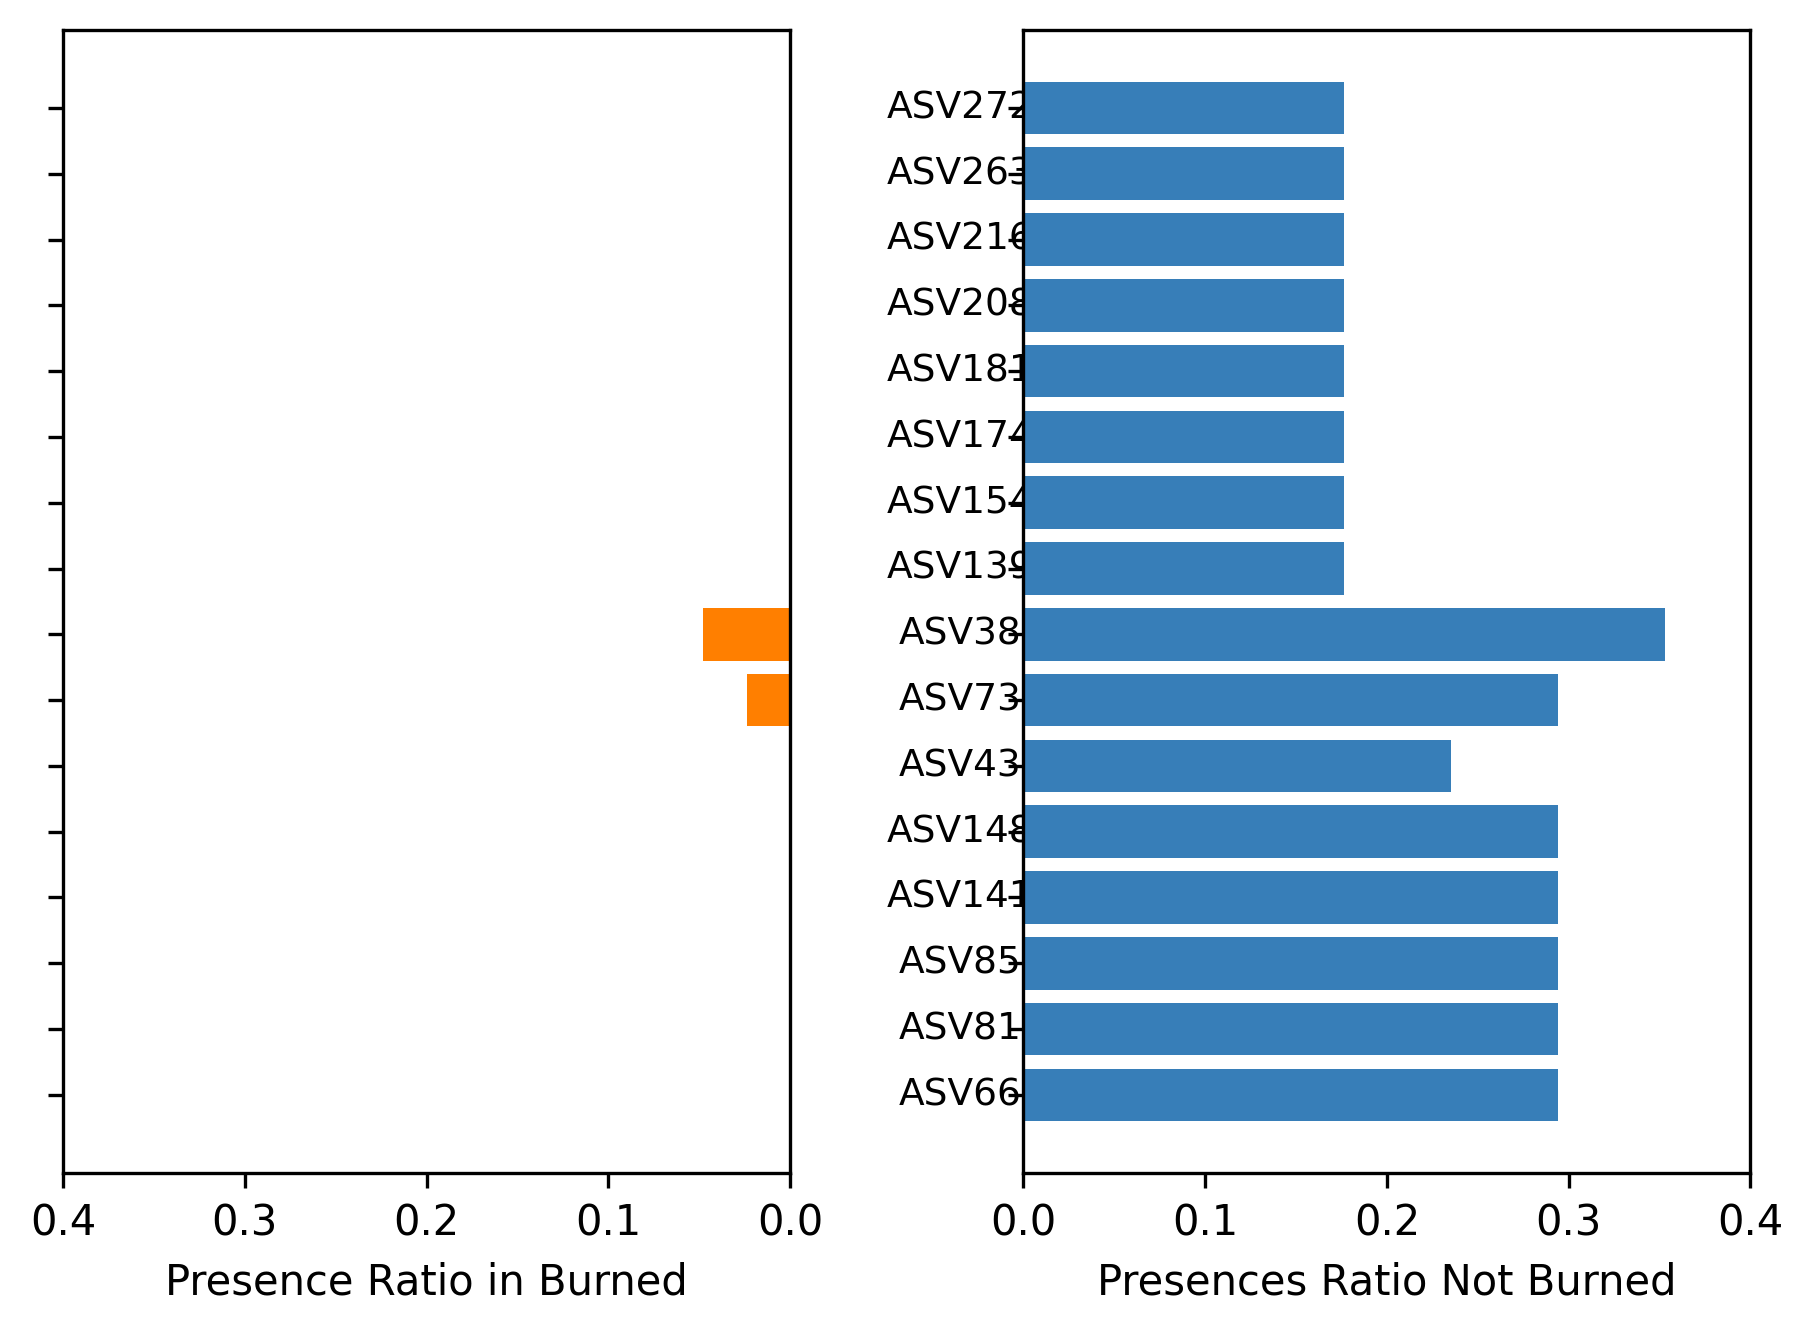

In [25]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=16
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]

df=pd.DataFrame(data=X_FS_15)
selectedASVs=[ASVs[i] for i in selectedOTU_index_15]

targetLabel=burn_label
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="Yes",posText="Burned",negText="Not Burned",entries=entries)


In [26]:
selectedASV_lasso = [ASVs[i] for i in xlabel_lasso]
RunML.plotPresenseRatio(X_lasso,targetLabel,selectedASV_lasso,posLabel="IBD",posText="IBD",negText="nonIBD",entries=len(selectedASV_lasso))

0 59


ZeroDivisionError: float division by zero